In [1]:
import numpy as np
import numpy.matlib as ml
import matplotlib.pyplot as plt
import math
from IPython.display import display, Math, Latex
from IPython.display import Markdown as md
from arr2ltx import convert2latex, to_latex

import estimator as e
import math

### Один цикл алгоритма расширенного фильтра Калмана
Initialize:<br>
$\hspace{8mm}x_{0 \mid 0}, P_{0 \mid 0}$<br>
Predict:<br>
$\hspace{8mm}x_{k+1 \mid k}=f\left(x_{k \mid k}, u^k\right) $<br>
$\hspace{8mm}P_{k+1 \mid k}=F_k^{(x)} P_{k \mid k} F_k^{(x) T}+F^{(v)} Q_k F^{(v) T}$<br>
$\hspace{8mm}z_{k+1 \mid k}=h\left(x_{k+1 \mid k}\right)$<br>
Update:<br>
$\hspace{8mm}S_{k+1}=H_{k+1}^{(x)} P_{k+1 \mid k} H_{k+1}^{(x) T}+H^{(w)} R_{k+1} H^{(w) T}$<br>
$\hspace{8mm}K_{k+1}=P_{k+1 \mid k} H_{k+1}^T S_{k+1}^{-1}$<br>
$\hspace{8mm}x_{k+1 \mid k+1}=x_{k+1 \mid k}+K_{k+1}\left(z_{k+1}-z_{k+1 \mid k}\right)$<br>
$\hspace{8mm}P_{k+1 \mid k+1}=P_{k+1 \mid k}-K_{k+1} S_{k+1} K_{k+1}^T$<br>
$\hspace{8mm}z_{k+1 \mid k+1}=h\left(x_{k+1 \mid k+1}\right)$<br>

Литература:
1. Multitarget-Multisensor Tracking: Principles and Techniques. Y. Bar-Shalom; X. Rong-Li, page 257 [\[1\]](multitarget-multisensor-tracking.pdf)
2. Fundamentals of Kalman Filtering—A Practical Approach, Second Edition. Paul Zarchan. [\[2\]](Fundamentals-of-Kalman-Filtering.pdf)
3. A study of QR decomposition and Kalman filter implementations, DAVID FUERTES RONCERO [\[3\]](A_study_of_QR_decomposition_and_Kalman_filter_impl.pdf) 

Расширенный фильтр Калмана (Extended Kalman Filter, EKF) – это расширение стандартного фильтра Калмана, предназначенное для работы с нелинейными динамическими системами.<br><br>
Стандартный фильтр Калмана хорошо работает только для линейных систем, где предполагается, что связь между состояниями и измерениями остается линейной. Однако многие реальные системы нелинейны по своей природе, и использование стандартного фильтра Калмана может привести к неточным оценкам.<br><br>
Расширенный фильтр Калмана позволяет учитывать нелинейные зависимости между состояниями и измерениями, используя линеаризацию в окрестности текущей оценки состояния. Основная идея заключается в том, чтобы линеаризовать нелинейные функции в уравнениях предсказания и коррекции фильтра Калмана. Это позволяет учитывать нелинейности и более точно оценивать состояние системы.<br><br>
Для уменьшение вычислительной сложности алгоритма расширенного фильра Калмана используют QR-разложение. Алгоритм приведён в [\[3\]](A_study_of_QR_decomposition_and_Kalman_filter_impl.pdf). 
Реализация алгоритма расширенного фильтра Калмана на языке С++ c QR-разложением в
[ekf.h](./../src/ekf.h)<br><br>
Линеаризация нелинейных функций выполняется с использованием матрицы частных производных - Якобиан. Расчёт Якобина происходит методом прямого численного дифференцирования.<br><br>


In [12]:
xs = np.array(['\hat{x_{c}}', '\hat{V_{x}}', '\hat{y_{c}}', '\hat{V_{y}}'])
xs = xs[:, np.newaxis]
zs = np.array(['\\alpha^{n}','r^{n}'])
zs = zs[:, np.newaxis]
xss = np.array(['x_{c}', 'V_{x}', 'y_{c}', 'V_{y}'])
xss = xss[:, np.newaxis]
Mz  = np.array([['\\cos(a)', 0], [0, 1]])
Rpos = np.array([['\\sqrt{D_{r}}', 0], [0, 'r\\sqrt{D_{ \\alpha}}']])
Pvel = np.array([['100', '0'], ['0', '100']])
Hcc = np.array([[1, 0, 0, 0],
               [0, 0, 1, 0]])
Hvv = np.array([[0, 1, 0, 0],
               [0, 0, 0, 1]])

x00 = np.array(['r \cdot cos(\\alpha)', '0', 'r \cdot sin(\\alpha)', '0'])
x00 = x00[:, np.newaxis] 

In [3]:
T = 0.2
process_var = 0.5

R = np.diag([1e-4, 1.0])

Qp = np.diag([process_var, process_var])
G = np.array([[T**2/2, 0],
             [T, 0],
             [0, T**2/2],
             [0, T]])
Q = G@Qp@G.T

initialState = np.array([-40., -2., 0., 0.])
initialState = initialState[:, np.newaxis]
max_speed = 4

## Пример
Расмотрим пример использования фильтра Калмана для кинематической модели движения второго порядка <br> (с компонетами координат и скоростью) в каждой из двух декартовых координат. Вектор оценки будет из себя представлять:<br>
<p style="text-align: center;">$\hat{x}=${{ Math(to_latex(xs)) }}</p>
где $\hat{x}_{c},\hat{y}_{c}$-декартовы координаты, $\hat{V}_{x},\hat{V}_{y}$-проекции скорости декартовых координат.<br><br>

Вектор наблюдений будет из себя представлять:<br>
<p style="text-align: center;"> $\hspace{5mm}z$={{ Math(to_latex(zs)) }}</p>
где $\alpha^{n},r^{n}$-полярные координаты азимут и дальность c добавлением шумов измерения, в моделировании зададим ковариационную матрицу шумов измерений как: <br>
<p style="text-align: center;"> $\hspace{5mm}R$={{ Math(to_latex(R))}}</p>
Дисперсии шума процесса зададим:
<p style="text-align: center;"> $Q_{k}$={{ Math(to_latex(Q)) }}</p><br><br>
«Маленькое» $Q_{k}$ дает движение «почти с постоянной скоростью».<br><br>
Зададим что темп поступления входных данных $T$=0.2 секунды.


## <a id='section_id'></a> Уравнение состояния и наблюдения
Динамика ветора состояния и связь вектора наблюдения и вектора состояния описывается функциями в [models.h](./../src/models.h)<br><br>
<pre>
```cpp
template <class M>
M stateModel(const M& x, double T) {
    M F = {{1, T, 0, 0},
           {0, 1, 0, 0},
           {0, 0, T, t},
           {0, 0, 0, 1}};
    return F*x;
};

template <class M>
M measureModel(const M& x, const M& z = M{}) {
    double angle = atan2(x(2), x(0));
    double range = sqrt(x(0)*x(0) + x(2)*x(2));
    if (!z.empty()) {
        angle = z(0) + Utils::ComputeAngleDifference(angle, z(0));
    }
    M r = {angle, range};
    return trans(r);
};
```
</pre>

In [4]:
def make_true_data(x0):
    X = np.zeros((x0.shape[0], 100))
    X[:, 0] = x0.T
    for i in range(X.shape[1]-1):
        xx = e.stateModel(np.copy(X[:, i]), T)
        X[:, i+1] = xx.flatten()
    return X

X=make_true_data(initialState)

## Моделирование

Для проверки правильности реализации алгоритма и сбора статистики результатов фильтрации линейного фильтра Калмана  выполним моделирование. Моделирование будет состоять следующих этапов: 
1. Получение траектории движения наблюдаемого обьекта; <br>
2. Из трактории движения получим измерения;<br>
3. Фильтрация алгоритом Калмана и построение графика для одной реализации;<br>
4. Повторение пунтков 1-3 и сбор статистики работы по N экспериментам и построеник графиков.

### Получение траектории движения обьекта
$x_{k+1}=A_{k}x_{k}$, $\hspace{5mm}x_{0}$ = {{ Math(to_latex(xss)) }} = {{ Math(to_latex(initialState)) }}
<br>
<br>
$X = ${{ Math(to_latex(X)) }}

In [5]:
def add_process_noise(X, Var):
    Xn = X + np.sqrt(Var) @ np.random.normal(loc=0, scale=1.0, size=(X.shape[0], X.shape[1]))
    return Xn
Xn = add_process_noise(X, Q)

### Добавление шума процесса к реальным данным
$
V = \begin{bmatrix}
    v_{11} & v_{12} & \cdots & v_{1n} \\
    v_{21} & v_{22} & \cdots & v_{2n} \\
    \vdots & \vdots & \ddots & \vdots \\
    v_{m1} & v_{m2} & \cdots & v_{mn}
\end{bmatrix}
\quad \text{где} \quad v_{ij} \sim N(0, 1)$, пусть матрицы $X$ и $V$ имеют одинаковые размеры
<br>
<br>
$X^{n}=X+\sqrt{G_{k}Q_{k}G^{T}_{k}}V$ = {{ Math(to_latex(Xn)) }}

In [6]:
def make_meas(X, R):
    Z = np.zeros((R.shape[0], X.shape[1]))
    for i in range(Z.shape[1]):
        zz = e.measureModel(np.copy(X[:, i]))
        Z[:, i] = zz.flatten()
    Zn = Z + np.sqrt(R) @ np.random.normal(loc=0, scale=math.sqrt(1.0), size=(Z.shape[0], Z.shape[1]))
    return Zn
Zn = make_meas(Xn, R)

### Получение измерений
С помощью уравнения наблюдения из вектора $X^{n}$ получем требуемы наблюдения и добавим к ним шумы измерения. 
$\sqrt{R}=${{ Math(to_latex(np.sqrt(Re))) }}
<br>
<br>
$
V = \begin{bmatrix}
    v_{11} & v_{12} & \cdots & v_{1n} \\
    v_{21} & v_{22} & \cdots & v_{2n} \\
    \vdots & \vdots & \ddots & \vdots \\
    v_{m1} & v_{m2} & \cdots & v_{mn}
\end{bmatrix}
\quad \text{где} \quad v_{ij} \sim N(0, 1)$, где матрицы $Z$ и $V$ имеют одинаковые размеры
<br>
<br>
$Z=measureModel(X^{n})+\sqrt{R}V$ = {{ Math(to_latex(Zn)) }}

## Инициализация фильтра Калмана

In [7]:
def rot_z(a):
    a = np.deg2rad(a)
    R = np.eye(3)
    ca = np.cos(a)
    sa = np.sin(a)
    R[0,0] = ca
    R[0,1] = -sa
    R[1,0] = sa
    R[1,1] = ca
    return R

def rot_y(a):
    a = np.deg2rad(a)
    R = np.eye(3,3)
    ca = np.cos(a)
    sa = np.sin(a)
    R[0,0] = ca
    R[0,2] = sa
    R[2,0] = -sa
    R[2,2] = ca
    return R

In [8]:
def sph2cart(measurement):
    cart = np.zeros(measurement.shape)
    for i in range(measurement.shape[1]):
        cart[0, i] = measurement[1, i] * math.cos(measurement[0, i])
        cart[1, i] = measurement[1, i] * math.sin(measurement[0, i])
    return cart

cart = sph2cart(Zn)

def sph2cartcov(sphCov, az, el, r):
    pa = 0
    pe = 1
    pr = 2
    pvr= 3

    azSig  = np.sqrt(sphCov[pa, pa])
    elSig  = np.sqrt(sphCov[pe, pe])
    rngSig = np.sqrt(sphCov[pr, pr])

    Rpos = np.diag([np.power(rngSig,2.0),
                    np.power(r*np.cos(np.deg2rad(el))*np.deg2rad(azSig), 2.0),
                    np.power(r*np.deg2rad(elSig), 2.0)])
    rot = rot_z(az)@rot_y(el).T
    posCov = rot@Rpos@rot.T
    if sphCov.shape==(4, 4):
        rrSig = np.sqrt(sphCov[pvr, pvr])
        crossVelSig = 10
        Rvel = np.diag([np.power(rrSig, 2.0), np.power(crossVelSig, 2.0), np.power(crossVelSig, 2.0)]);
        velCov = rot@Rvel@rot.T
    else:
        velCov = 100*np.eye(3)
        
    return posCov, velCov


def make_cartcov(meas, covMeas):
    az = np.rad2deg(meas[0,0])
    el = 0
    r  = meas[1,0]
    sphCov = np.diag([covMeas[0,0], 0, covMeas[1,1]])
    [posCov, velCov] = sph2cartcov(sphCov, az, el, r)
    posCov = posCov[0:2,0:2]
    velCov = velCov[0:2,0:2]
    Hp = np.array([[1, 0, 0, 0],
                   [0, 0, 1, 0]])
    Hv = np.array([[0, 1, 0, 0],
                   [0, 0, 0, 1]])
    return Hp.T@posCov@Hp + Hv.T@velCov@Hv


def make_kalman_filter(measurement):
    Hp = np.array([[1, 0, 0, 0],
                   [0, 0, 1, 0]])
    x0 = sph2cart(measurement)
    x0 = Hp.T@x0
    P0  = make_cartcov(measurement, R)
    kf = e.Ekf(x0, P0, Q, R)
    return kf

Получить ковариационную матрицу ошибок декартовых координат из полярной можно получить как:
<p style="text-align: center;"> $P^{c}_{0|0}=M_z(\alpha)R_{pos}M_z(\alpha)^{T}$

Где $M_z(\alpha)$ - матрица поворота. Подробно [матрицы поворота](https://ru.wikipedia.org/wiki/%D0%9C%D0%B0%D1%82%D1%80%D0%B8%D1%86%D0%B0_%D0%BF%D0%BE%D0%B2%D0%BE%D1%80%D0%BE%D1%82%D0%B0):

<p style="text-align: center;"> $M_z(\alpha)$={{ Math(to_latex( Mz )) }}<br>

Матица $R_{pos}$ задаётся как:
<p style="text-align: center;"> $R_{pos}$={{ Math(to_latex( Rpos )) }}<br>

Где $\alpha$ - азимут цели, $r$ - дальность цели, $D_{\alpha}$ - дисперсия ошибок измерения по азимту, $D_{r}$ - дисперсия ошибок по дальности.
    
Ковариационную матрицу ошибок проекций скорости зададим как:
<p style="text-align: center;"> $P^{v}_{0|0}$={{ Math(to_latex( Pvel )) }}<br>

Ковариционную матрицу ошибок будем задавать как:
<p style="text-align: center;"> $P_{0|0}$=$H_{с}P^{с}_{0|0}H_{с}^{T}+H_{v}P^{v}_{0|0}H_{v}^{T}$<br>

Где матрицы
<p style="text-align: center;"> $H_{c}$={{ Math(to_latex( Hcc )) }}<br><br>
<p style="text-align: center;"> $H_{v}$={{ Math(to_latex( Hvv )) }}<br><br>
    
Начальный вектор оценок зададим как: 
<p style="text-align: center;"> $x_{0|0}$={{ Math(to_latex( x00 )) }} <br><br>
    

### Построение графиков оценки по одной реализации

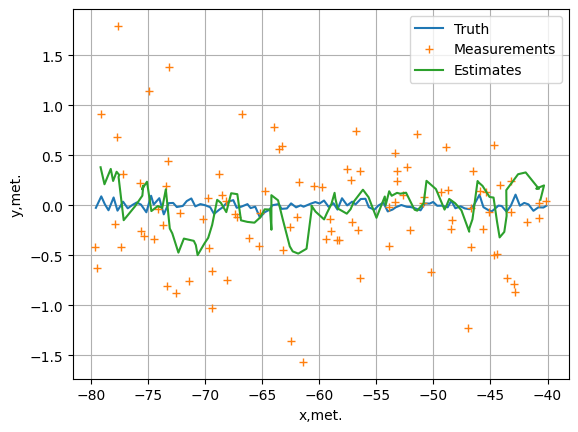

In [13]:
def step(Z, make_estimator):
    estimator = make_estimator(Z[:, 0][:, np.newaxis])
    est = np.zeros((initialState.shape[0], Z.shape[1]-1))

    for col in range(est.shape[1]):
        z = Z[:, col + 1]
        xp, _ = estimator.predictStateModel(T)
        m1 = np.array([z[0], z[1]])
        xc, _ = estimator.correctMeasureModel(m1.T)
        est[:, col] = np.squeeze(xc[:])

    return est

est=step(Zn, make_kalman_filter)

plt.figure()
plt.plot(Xn[0, :], Xn[2, :], label='Truth')
plt.plot(cart[0, :], cart[1, :], label='Measurements', linestyle='', marker='+')
plt.plot(est[0, :], est[2, :], label='Estimates')
plt.xlabel('x,met.')
plt.ylabel('y,met.')
plt.grid(True)
plt.legend()
plt.show()

### Сбор статистики по наботу экспериментов

100%|██████████████████████████████████████| 2000/2000 [00:07<00:00, 274.76it/s]


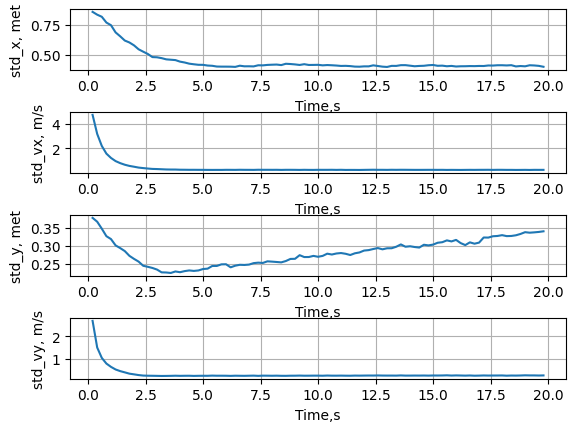

In [16]:
def calc_err(X, make_estimator):
    Xn = add_process_noise(X, Q)
    Zn = make_meas(Xn, R)
    est = step(Zn, make_estimator)
    err = est - Xn[:, 1:]
    return err

from tqdm import tqdm

def calc_std_err(X, make_estimator):
    num_iterations = 2000
    var_err = np.zeros((X.shape[0], X.shape[1]-1))

    for i in tqdm(range(num_iterations)):
        err = calc_err(X, make_estimator)
        var_err += err ** 2

    var_err /= num_iterations
    return np.sqrt(var_err)

std_err = calc_std_err(X, make_kalman_filter)

plt.figure()
plt.subplot(4, 1, 1)
plt.plot((np.arange(len(std_err[0, :]))+1)*T, std_err[0, :].T)
plt.xlabel('Time,s')
plt.ylabel('std_x, met')
plt.grid(True)
plt.subplot(4, 1, 2)
plt.plot((np.arange(len(std_err[1, :]))+1)*T, std_err[1, :].T)
plt.grid(True)
plt.xlabel('Time,s')
plt.ylabel('std_vx, m/s')
plt.subplot(4, 1, 3)
plt.plot((np.arange(len(std_err[2, :]))+1)*T, std_err[2, :].T)
plt.grid(True)
plt.xlabel('Time,s')
plt.ylabel('std_y, met')
plt.subplot(4, 1, 4)
plt.plot((np.arange(len(std_err[3, :]))+1)*T, std_err[3, :].T)
plt.grid(True)
plt.xlabel('Time,s')
plt.ylabel('std_vy, m/s')
plt.subplots_adjust(wspace=8.0, hspace=0.7)
plt.show()